# 7.1 音源方向推定に基づく音源分離

* 空間モデルだけでは、空間モデルのパラメータをすべて決定することはできず、事前情報が必要
  * DSBF, MVDR: 目的音のステアリングベクトルを事前情報として利用
  * MaxSNR, MWF: 雑音のみが存在する区間が既知で、雑音のみの区間の情報を事前情報として利用
    * しかし、雑音のみが存在する区間の情報を得るのが非現実的だし、常に雑音の性質が定常でないといけないという制約がある
* BSS (Blind Source Separation: ブラインド音源分離)
  * 特定の音源だけが存在する時間がわからない条件のもと、音源を分離する技術
  * マイクロホン配置も未知であることを仮定することが一般的
  * 最初は仮定を緩めて、マイクロホン配置ととりたい音の方向（目的音の方向）はわかっていると仮定
  * ステアリングベクトルは正確にはわからないということを前提にする
* 本章でフォーカスする課題は、混合音中からいかに空間モデルのパラメータを推定するか
* パラメータが求まったあとは、前述の BF を利用して音源分離可能なフレームワークを示す
* ステアリングベクトルが実際のステアリングベクトルから乖離している可能性を考慮
* 空間モデルを推定するために、音声らしさのモデルとして、時間周波数領域における **音声のスパース性** を仮定
  * 音声のスパース性：各音声が同じ時間周波数成分を共有する確立は稀であるということから、ある時間周波数成分を有する音源は一つだけであるという過程
  * 逆に白色雑音は、すべての周波数帯域に均等にエネルギーが分散している
* つまり、スペクトログラムの一つのマスは、一つの音源で構成されている

# 7.2 音声のスパース性に基づく音源分離

* 時間周波数ごとに、支配的な音源のインデックスを推定する
* そのためには、音源方向の情報
* 時間周波数ごとの支配的な音源を見分けるための情報として、複数のマイクロホン間の振幅比と位相比の情報が使える
* 音源が遠い場合：Far-field 仮定
  * マイクロホン間の位相差を用いて、$i(l,k)$ は次のように推定可能
* 音源が近い場合：Near-field 仮定
  * マイクロホン間の振幅比を用いて、$i(l,k)$ は次のように推定可能

In [15]:
import wave
import pyroomacoustics as pa
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt


def plot_spectrogram(data, sample_rate):
    """データからスペクトログラムを作成し、それをプロットする関数

    Parameters:
    data: numpy array
        音声データ
    sample_rate: int
        サンプリングレート（Hz）
    """
    fig = plt.figure(figsize=(10, 4))
    spectrum, freqs, t, im = plt.specgram(data, NFFT=512, noverlap=int(512 / 16 * 15), Fs=sample_rate, cmap="inferno")
    fig.colorbar(im).set_label("Intensity [dB]")
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()


def write_file_from_time_signal(signal, file_name, sample_rate, display=False):
    signal = signal.astype(np.int16)
    if display == True:
        plot_spectrogram(signal, sample_rate)
    with wave.open(file_name, "w") as wave_out:
        wave_out.setnchannels(1)
        wave_out.setsampwidth(2)
        wave_out.setframerate(sample_rate)
        wave_out.writeframes(signal)


# 遅延和アレイを実行する
# x_left:左の音源に近いマイクロホン(Nk, Lt)
# x_right:右の音源に近いマイクロホン(Nk,Lt)
# is_use_amplitude: 振幅差を使って分離を行う場合はTrue
# return y_left 左のマイクに近い音源の出力信号(Nk, Lt)
#       y_right 右のマイクに近い音源の出力信号(Nk,Lt)
def execute_two_microphone_sparse_separation(x_left, x_right, is_use_amplitude=False):
    if is_use_amplitude == True:
        # 振幅比率を使った分離
        amp_ratio = np.abs(x_left) / np.maximum(np.abs(x_right), 1.0e-18)
        y_left = (amp_ratio > 1.0).astype(float) * x_left
        y_right = (amp_ratio <= 1.0).astype(float) * x_right
    else:
        # 位相差を用いた分離
        phase_difference = np.angle(x_left / x_right)
        y_left = (phase_difference > 0.0).astype(float) * x_left
        y_right = (phase_difference <= 0.0).astype(float) * x_right
    return (y_left, y_right)


# SNRをはかる
# desired: 目的音、Lt
# out: 雑音除去後の信号 Lt
def calculate_snr(desired, out):
    wave_length = np.minimum(np.shape(desired)[0], np.shape(out)[0])
    # 消し残った雑音
    desired = desired[:wave_length]
    out = out[:wave_length]
    noise = desired - out
    snr = 10.0 * np.log10(np.sum(np.square(desired)) / np.sum(np.square(noise)))
    return snr


np.random.seed(0)

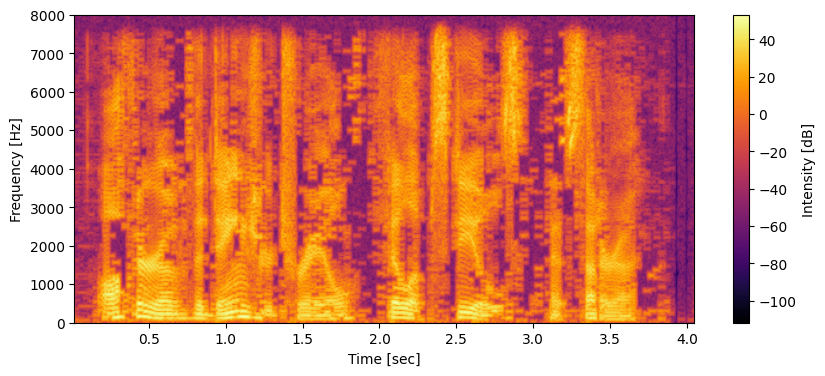

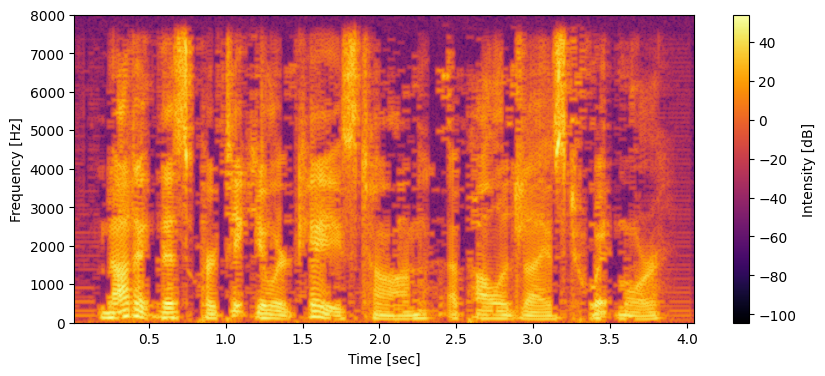

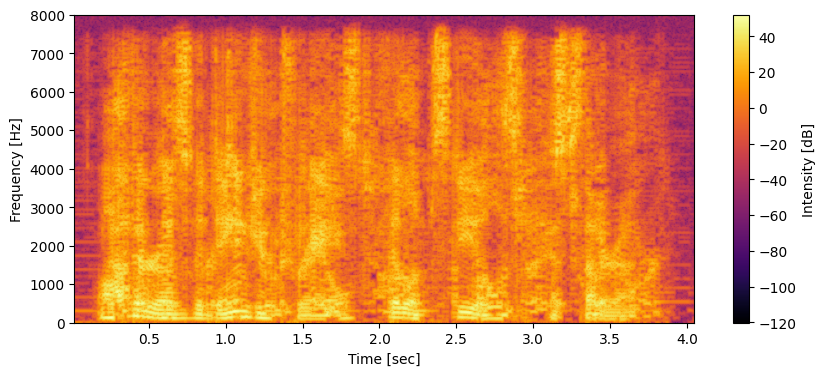

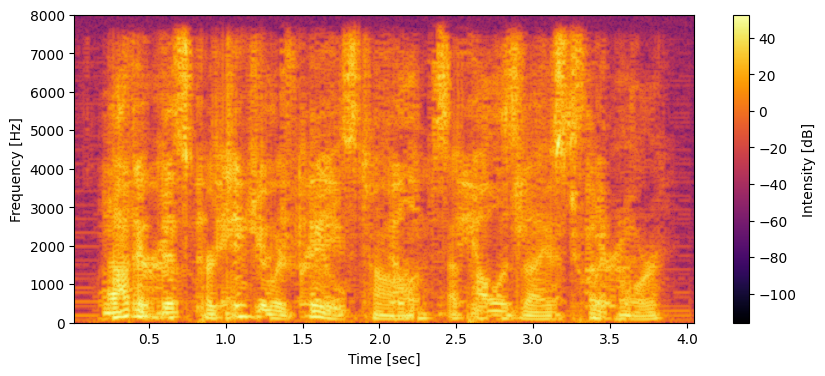

method:     PHASE AMPLITUDE
Δsnr [dB]: 6.90 2.95


In [16]:
clean_wave_files = ["../arctic_a0001.wav", "../arctic_a0002.wav"]
n_sources = len(clean_wave_files)

n_samples = 0
for clean_wave_file in clean_wave_files:
    with wave.open(clean_wave_file) as wav:
        if n_samples < wav.getnframes():
            n_samples = wav.getnframes()

clean_data = np.zeros([n_sources, n_samples])

# ファイルを読み込む
for s, clean_wave_file in enumerate(clean_wave_files):
    with wave.open(clean_wave_file) as wav:
        data = wav.readframes(wav.getnframes())
        data = np.frombuffer(data, dtype=np.int16)
        data = data / np.iinfo(np.int16).max
        clean_data[s, : wav.getnframes()] = data

# シミュレーションのパラメータ
n_sim_sources = 2
sample_rate = 16000
N = 1024
Nk = int(N / 2 + 1)
freqs = np.arange(0, Nk, 1) * sample_rate / N
SNR = 90.0
room_dim = np.r_[10.0, 10.0, 10.0]
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1
mic_alignments = np.array([[x, 0.0, 0.0] for x in np.arange(-0.01, 0.02, 0.02)])
n_channels = np.shape(mic_alignments)[0]
R = mic_alignments.T + mic_array_loc[:, None]

# 部屋を生成する
room = pa.ShoeBox(room_dim, fs=sample_rate)
room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

# 用いるマイクロホンアレイの情報を設定する
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

# 音源の場所
doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])

# 音源とマイクロホンの距離
distance = 1.0
source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

# 各音源をシミュレーションに追加する
for s in range(n_sim_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])
    if s == 0:
        room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
    if s == 1:
        room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

# シミュレーションを回す
room.simulate(snr=SNR)
room_no_noise_left.simulate(snr=90)
room_no_noise_right.simulate(snr=90)

# 畳み込んだ波形を取得する(チャンネル、サンプル）
multi_conv_data = room.mic_array.signals
multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

write_file_from_time_signal(multi_conv_data_left_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./far_left_clean.wav", sample_rate)
write_file_from_time_signal(multi_conv_data_right_no_noise[1, :] * np.iinfo(np.int16).max / 20.0, "./far_right_clean.wav", sample_rate)
write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./far_in_left.wav", sample_rate)
write_file_from_time_signal(multi_conv_data[1, :] * np.iinfo(np.int16).max / 20.0, "./far_in_right.wav", sample_rate)

# 短時間フーリエ変換を行う
f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

# 位相差もしくは振幅差で分離
y_phase_left, y_phase_right = execute_two_microphone_sparse_separation(stft_data[0, ...], stft_data[1, ...], False)
y_amp_left, y_amp_right = execute_two_microphone_sparse_separation(stft_data[0, ...], stft_data[1, ...], True)

# 時間領域の波形に戻す
t, y_phase_left = sp.istft(y_phase_left, fs=sample_rate, window="hann", nperseg=N)
t, y_phase_right = sp.istft(y_phase_right, fs=sample_rate, window="hann", nperseg=N)
t, y_amp_left = sp.istft(y_amp_left, fs=sample_rate, window="hann", nperseg=N)
t, y_amp_right = sp.istft(y_amp_right, fs=sample_rate, window="hann", nperseg=N)

# SNRをはかる
snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) \
        + calculate_snr(multi_conv_data_right_no_noise[1, ...], multi_conv_data[1, ...])
snr_phase_post = calculate_snr(multi_conv_data_left_no_noise[0, ...], y_phase_left) \
               + calculate_snr(multi_conv_data_right_no_noise[1, ...], y_phase_right)
snr_amp_post = calculate_snr(multi_conv_data_left_no_noise[0, ...], y_amp_left) \
             + calculate_snr(multi_conv_data_right_no_noise[1, ...], y_amp_right)
snr_pre /= 2.0
snr_phase_post /= 2.0
snr_amp_post /= 2.0

# ファイルに書き込む
write_file_from_time_signal(y_phase_left * np.iinfo(np.int16).max / 20.0, "./far_sparse_phase_left.wav", sample_rate, display=True)
write_file_from_time_signal(y_phase_right * np.iinfo(np.int16).max / 20.0, "./far_sparse_phase_right.wav", sample_rate, display=True)
write_file_from_time_signal(y_amp_left * np.iinfo(np.int16).max / 20.0, "./far_sparse_amp_left.wav", sample_rate, display=True)
write_file_from_time_signal(y_amp_right * np.iinfo(np.int16).max / 20.0, "./far_sparse_amp_right.wav", sample_rate, display=True)

print("method:    ", "PHASE", "AMPLITUDE")
print(f"Δsnr [dB]: {(snr_phase_post - snr_pre):.2f} {(snr_amp_post - snr_pre):.2f}")

* `execute_two_microphone_sparse_separation` 関数
  * マイクロホンアレイ間の位相さもしくは振幅比に基づき $i(l,k)$ を推定して音源分離
  * is_amplitude_enabled が True の場合は振幅比に基づく音源分離
  * is_amplitude_enabled が False の場合は位相差に基づく音源分離
* 位相差を用いた結果 PHASE のほうが、振幅比を用いた結果 AMPLITUDE よりもよい結果となった
* 上記のプログラムでは、マイク間距離が 2cm で、マイクと音源の距離 1m と比較して間隔が短いため、Far-field 仮定が成立する
  * そのため、位相差を用いた結果がよい結果となった
* 時間周波数成分によっては 2 つの音源が混ざることがあり、そのような時間周波数成分では、一方の音源がごっそり抜け落ちている

* マイクロホン間隔を 40cm に変更すると、Near-field 仮定が成立

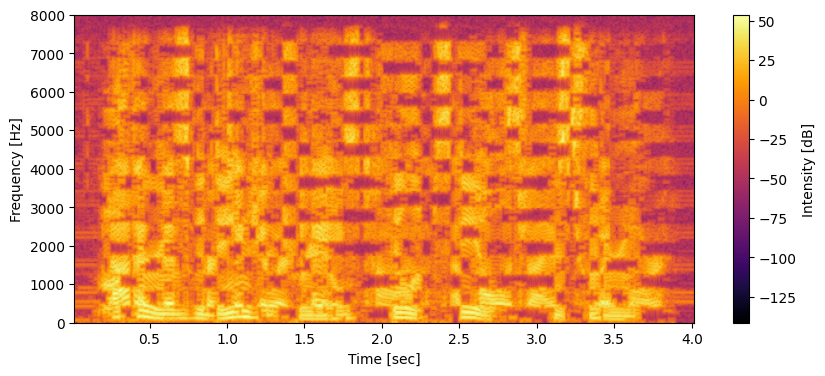

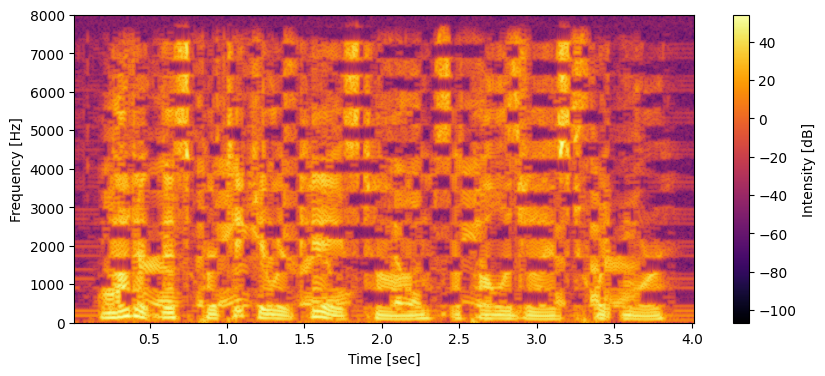

c:\Users\ohya\Anaconda3\envs\audio\lib\site-packages\matplotlib\axes\_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


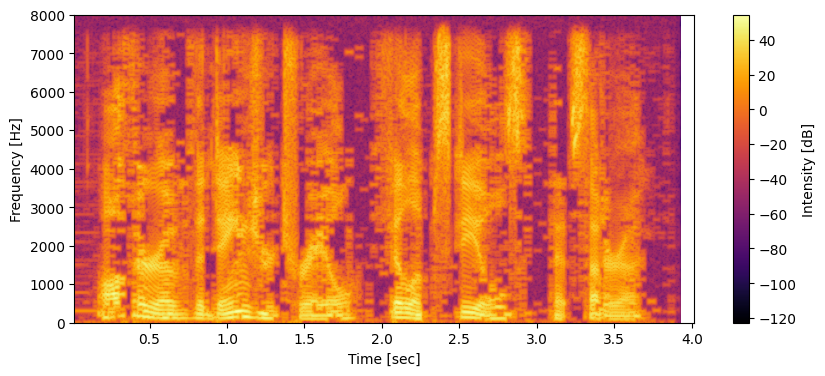

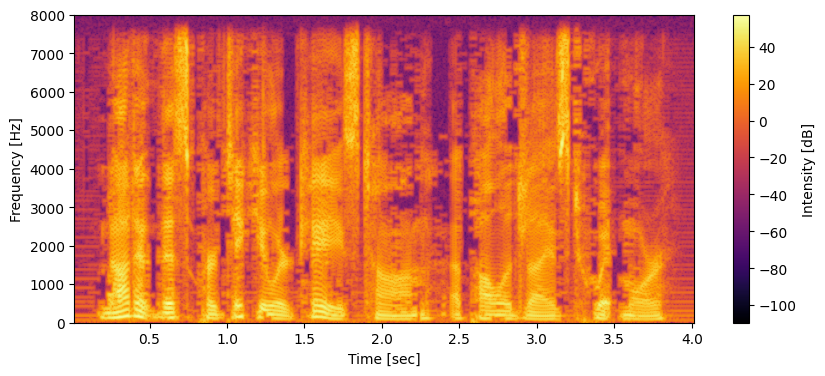

method:     PHASE AMPLITUDE
Δsnr [dB]: -0.96 4.17


In [18]:
# マイクロホンアレイのマイク配置
mic_alignments = np.array([[x, 0.0, 0.0] for x in np.arange(-0.2, 0.21, 0.4)])

# マイクロホン数
n_channels = np.shape(mic_alignments)[0]

# マイクロホンアレイの座標
R = mic_alignments.T + mic_array_loc[:, None]

# 部屋を生成する
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

# 用いるマイクロホンアレイの情報を設定する
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

# 音源の場所
doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0.0]])

# 音源とマイクロホンの距離
distance = 1.0
source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

# 各音源をシミュレーションに追加する
for s in range(n_sim_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])
    if s == 0:
        room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
    if s == 1:
        room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

# シミュレーションを回す
room.simulate(snr=SNR)
room_no_noise_left.simulate(snr=90)
room_no_noise_right.simulate(snr=90)

# 畳み込んだ波形を取得する(チャンネル、サンプル）
multi_conv_data = room.mic_array.signals
multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

write_file_from_time_signal(multi_conv_data_left_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./near_left_clean.wav", sample_rate)
write_file_from_time_signal(multi_conv_data_right_no_noise[1, :] * np.iinfo(np.int16).max / 20.0, "./near_right_clean.wav", sample_rate)
write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./near_in_left.wav", sample_rate)
write_file_from_time_signal(multi_conv_data[1, :] * np.iinfo(np.int16).max / 20.0, "./near_in_right.wav", sample_rate)

# 短時間フーリエ変換を行う
f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

# 位相差もしくは振幅差で分離
y_phase_left, y_phase_right = execute_two_microphone_sparse_separation(stft_data[0, ...], stft_data[1, ...], False)
y_amp_left, y_amp_right = execute_two_microphone_sparse_separation(stft_data[0, ...], stft_data[1, ...], True)

# 時間領域の波形に戻す
t, y_phase_left = sp.istft(y_phase_left, fs=sample_rate, window="hann", nperseg=N)
t, y_phase_right = sp.istft(y_phase_right, fs=sample_rate, window="hann", nperseg=N)
t, y_amp_left = sp.istft(y_amp_left, fs=sample_rate, window="hann", nperseg=N)
t, y_amp_right = sp.istft(y_amp_right, fs=sample_rate, window="hann", nperseg=N)

# SNRをはかる
snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) \
        + calculate_snr(multi_conv_data_right_no_noise[1, ...], multi_conv_data[1, ...])
snr_phase_post = calculate_snr(multi_conv_data_left_no_noise[0, ...], y_phase_left) \
               + calculate_snr(multi_conv_data_right_no_noise[1, ...], y_phase_right)
snr_amp_post = calculate_snr(multi_conv_data_left_no_noise[0, ...], y_amp_left) \
             + calculate_snr(multi_conv_data_right_no_noise[1, ...], y_amp_right)
snr_pre /= 2.0
snr_phase_post /= 2.0
snr_amp_post /= 2.0

# ファイルに書き込む
write_file_from_time_signal(y_phase_left * np.iinfo(np.int16).max / 20.0, "./near_sparse_phase_left.wav", sample_rate, display=True)
write_file_from_time_signal(y_phase_right * np.iinfo(np.int16).max / 20.0, "./near_sparse_phase_right.wav", sample_rate, display=True)
write_file_from_time_signal(y_amp_left * np.iinfo(np.int16).max / 20.0, "./near_sparse_amp_left.wav", sample_rate, display=True)
write_file_from_time_signal(y_amp_right * np.iinfo(np.int16).max / 20.0, "./near_sparse_amp_right.wav", sample_rate, display=True)

print("method:    ", "PHASE", "AMPLITUDE")
print(f"Δsnr [dB]: {(snr_phase_post - snr_pre):.2f} {(snr_amp_post - snr_pre):.2f}")

* マイクロホン間での振幅比を使った分離法のほうが高い性能を示す

* マイクロホン間隔が広がるほど、マイクロホン間の音の到来時間差が大きくなり性能は向上するが、$2\pi$ 以上の位相差ができる距離になると、位相差から方向を一つに定められなくなる（**空間的エイリアシング**）
* 高い周波数ほど空間的エイリアシングが生じるマイクロホン間隔が短いため、最も高い周波数で空間的エイリアシングが起こらないように間隔を設定する必要がある$$d \leq \frac{c}{2f_{max}}$$
* サンプリング周波数が 16KHz の場合は、約 2cm（TAMAGO は 3cm）

* 音声のスパース性を用いた音源分離法を任意のマイクロホン数、配置に拡張することを考える
* それぞれのマイクロホンに最も早く、もしくは最も大きく届く音を取得する方法について議論を進めてきたが、億艇の範囲に存在する音を抽出するというように拡張
  * 方位角 $\theta$ から $\pm\Delta\theta$ の範囲に存在する音源を抽出する
$$
y_{\Omega,lk} =
\begin{cases}
x_{lk} & \text{if } \theta_{lk} \in \Omega, \\
0 & \text{otherwise}.
\end{cases}
$$
  * 音源のスパース性に基づき、次が言える$$x_{lk} \approx s_{i(l,k),lk} a_{i(l,k),k}$$
  * したがって$$|a_{\theta, k}^H x_{lk}|^2 = |s_{i(l,k),lk}|^2 |a_{\theta, k}^H a_{i(l,k),k}|^2$$
  * 右辺が $a_{\theta, k} = a_{i(l,k),k}$ のとき最大となるため、以下のように時間周波数ごとの音源方向を推定可能$$\theta_{lk} = \arg\max_{\theta} |a_{\theta, k}^H x_{lk}|^2$$
  * 方位角と仰角の双方を推定することも可能

In [20]:
# ステアリングベクトルを算出
# mic_position: 3 x M  dimensional ndarray [[x,y,z],[x,y,z]]
# source_position: 3x Ns dimensional ndarray [[x,y,z],[x,y,z] ]
# freqs: Nk dimensional array [f1,f2,f3...]
# sound_speed: 音速 [m/s]
# is_use_far: Farを使う場合はTrue, Nearの場合はFalse,
# return: steering vector (Nk x Ns x M)
def calculate_steering_vector(mic_alignments, source_locations, freqs, sound_speed=340, is_use_far=False):
    # マイク数を取得
    n_channels = np.shape(mic_alignments)[1]
    # 音源数を取得
    n_source = np.shape(source_locations)[1]
    if is_use_far == True:
        # 音源位置を正規化
        norm_source_locations = source_locations / np.linalg.norm(source_locations, 2, axis=0, keepdims=True)
        # 位相を求める
        steering_phase = np.einsum("k,ism,ism->ksm", 2.0j * np.pi / sound_speed * freqs, norm_source_locations[..., None], mic_alignments[:, None, :])
        # ステアリングベクトルを算出
        steering_vector = 1.0 / np.sqrt(n_channels) * np.exp(steering_phase)
        return steering_vector

    else:
        # 音源とマイクの距離を求める
        # distance: Ns x Nm
        distance = np.sqrt(np.sum(np.square(source_locations[..., None] - mic_alignments[:, None, :]), axis=0))
        # 遅延時間(delay) [sec]
        delay = distance / sound_speed
        # ステアリングベクトルの位相を求める
        steering_phase = np.einsum("k,sm->ksm", -2.0j * np.pi * freqs, delay)
        # 音量の減衰
        steering_decay_ratio = 1.0 / distance
        # ステアリングベクトルを求める
        steering_vector = steering_decay_ratio[None, ...] * np.exp(steering_phase)
        # 大きさを1で正規化する
        steering_vector = steering_vector / np.linalg.norm(steering_vector, 2, axis=2, keepdims=True)
    return steering_vector


# スパース性に基づく分離
# input_vectors:マイクロホン入力信号(Nm,Nk, Lt)
# steering_vectors:ステアリングベクトル(Nk,|Ω|,Nm)
# omega: 目的音の範囲(Ns,|Ω|)
# return y：出力信号(Nm,Ns,Nk, Lt)
def execute_doa_sparse_separation(input_vectors, steering_vectors, omega):
    inner_product = np.einsum("kim,mkt->kit", np.conjugate(steering_vectors), input_vectors)
    n_omega = np.shape(omega)[1]
    estimate_doas = np.argmax(np.abs(inner_product), axis=1)
    estimate_doa_mask = np.identity(n_omega)[estimate_doas]
    output_mask = np.einsum("kti,si->skt", estimate_doa_mask, omega)
    y = np.einsum("skt,mkt->mskt", output_mask, input_vectors)
    return y

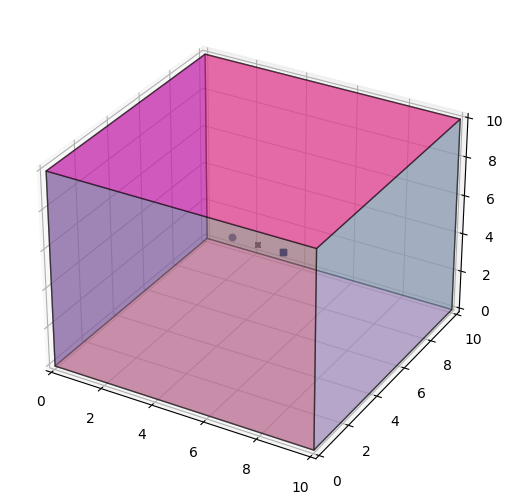

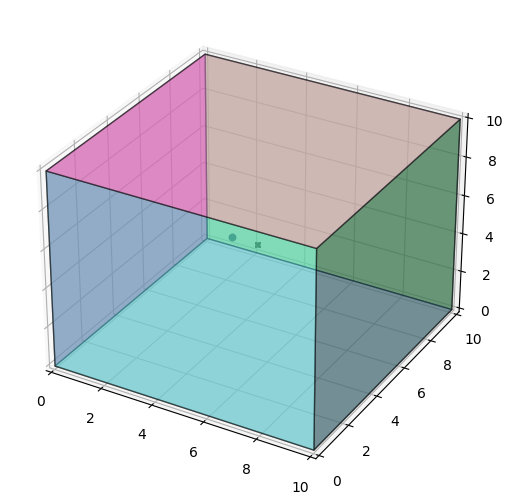

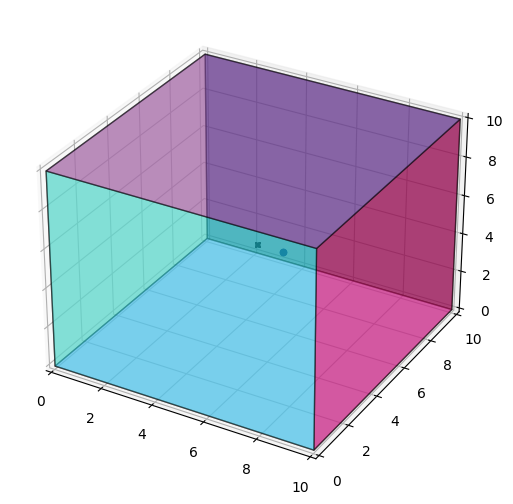

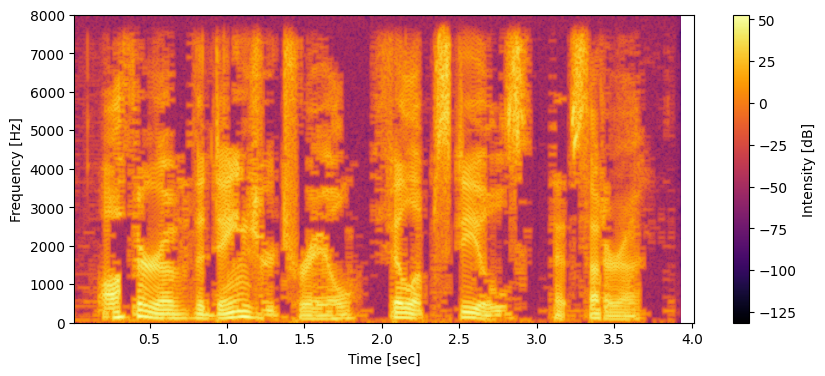

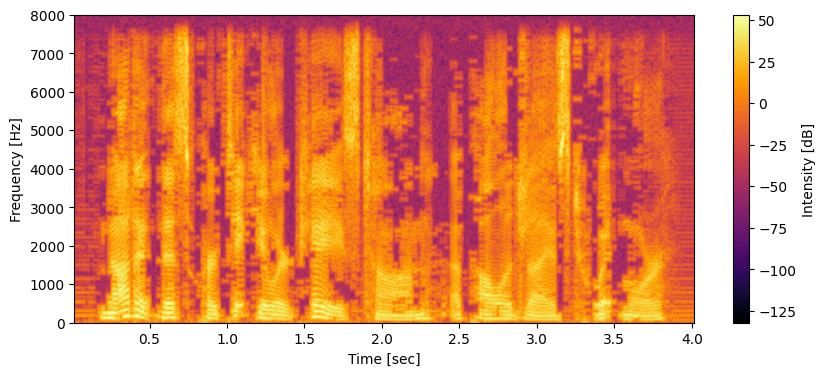

method:     DOA
Δsnr [dB]: 7.89


In [27]:
clean_wave_files = ["../arctic_a0001.wav", "../arctic_a0002.wav"]

SNR = 90.0

# 方位角の閾値
azimuth_th = 30.0

room_dim = np.r_[10.0, 10.0, 10.0]
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1
# 半径 2cm の円状にマイクを配置（10度刻み）
mic_directions = np.array([[np.pi / 2.0, theta / 180.0 * np.pi] for theta in np.arange(0, 360, 10)])
distance = 0.02
mic_alignments = np.zeros((3, mic_directions.shape[0]), dtype=mic_directions.dtype)
mic_alignments[0, :] = np.cos(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[1, :] = np.sin(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[2, :] = np.cos(mic_directions[:, 0])
mic_alignments *= distance

# マイクロホン数
n_channels = np.shape(mic_alignments)[1]

# マイクロホンアレイの座標
R = mic_alignments + mic_array_loc[:, None]

# 部屋を生成する
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

# 用いるマイクロホンアレイの情報を設定する
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

# 音源の場所
doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])

# 音源とマイクロホンの距離
distance = 1.0
source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

# ステアリングベクトルを算出するための仮想的な音源方向
virtual_doas = np.array([[np.pi / 2.0, theta / 180.0 * np.pi] for theta in np.arange(0, 360, 5)])
virtual_source_locations = np.zeros((3, virtual_doas.shape[0]), dtype=virtual_doas.dtype)
virtual_source_locations[0, :] = np.cos(virtual_doas[:, 1]) * np.sin(virtual_doas[:, 0])
virtual_source_locations[1, :] = np.sin(virtual_doas[:, 1]) * np.sin(virtual_doas[:, 0])
virtual_source_locations[2, :] = np.cos(virtual_doas[:, 0])
virtual_source_locations *= 100.0
virtual_source_locations += mic_array_loc[:, None]

# 仮想的な音源方向のステアリングベクトル作成
# virtual steering vector: (Nk x Ns x M)
virtual_steering_vectors = calculate_steering_vector(R, virtual_source_locations, freqs, is_use_far=True)


def modify_angle_diff(diff):
    diff = np.where(diff < -np.pi, diff + np.pi * 2, diff)
    diff = np.where(diff > np.pi, diff - np.pi * 2, diff)
    return diff


# 所望音の方向から±th度以内
omega = np.array([np.abs(modify_angle_diff(virtual_doas[:, 1] - doas[s, 1])) < azimuth_th / 180.0 * np.pi for s in range(n_sim_sources)]).astype(float)

# 各音源をシミュレーションに追加する
for s in range(n_sim_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])
    if s == 0:
        room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
    if s == 1:
        room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

room.plot()
room_no_noise_left.plot()
room_no_noise_right.plot()
# シミュレーションを回す
room.simulate(snr=SNR)
room_no_noise_left.simulate(snr=90)
room_no_noise_right.simulate(snr=90)

# 畳み込んだ波形を取得する(チャンネル、サンプル）
multi_conv_data = room.mic_array.signals
multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

write_file_from_time_signal(multi_conv_data_left_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./doa_left_clean.wav", sample_rate)
write_file_from_time_signal(multi_conv_data_right_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./doa_right_clean.wav", sample_rate)
write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./doa_in_left.wav", sample_rate)
write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./doa_in_right.wav", sample_rate)

# 短時間フーリエ変換を行う
f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

# DOA情報を使って分離
y_doa = execute_doa_sparse_separation(stft_data, virtual_steering_vectors, omega)


# 時間領域の波形に戻す
t, y_doa_left = sp.istft(y_doa[0, 0, ...], fs=sample_rate, window="hann", nperseg=N)
t, y_doa_right = sp.istft(y_doa[0, 1, ...], fs=sample_rate, window="hann", nperseg=N)

# SNRを計算
snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) \
        + calculate_snr(multi_conv_data_right_no_noise[0, ...], multi_conv_data[0, ...])
snr_doa_post = calculate_snr(multi_conv_data_left_no_noise[0, ...], y_doa_left) \
             + calculate_snr(multi_conv_data_right_no_noise[0, ...], y_doa_right)
snr_pre /= 2.0
snr_doa_post /= 2.0

# ファイルに書き込む
write_file_from_time_signal(y_doa_left * np.iinfo(np.int16).max / 20.0, "./sparse_doa_left.wav", sample_rate, display=True)
write_file_from_time_signal(y_doa_right * np.iinfo(np.int16).max / 20.0, "./sparse_doa_right.wav", sample_rate, display=True)

print("method:    ", "DOA")
print(f"Δsnr [dB]: {(snr_doa_post - snr_pre):.2f}")

* 0 deg と 180 deg からそれぞれ 30 deg 以内にある音源を分離
* マイクロホン素子数を 36 にすると 2 の場合と比較して、音源分離性能が向上

# 7.3 音声のスパース性とビームフォーミングの統合